In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

/usr/lib64/python2.7/site-packages/matplotlib/__init__.py:1005: UserWarning:  This call to matplotlib.use() has no effect
because the the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
('Epoch:', '0001', 'cost=', '0.100655407')
('Epoch:', '0002', 'cost=', '0.086166769')
('Epoch:', '0003', 'cost=', '0.083134905')
('Epoch:', '0004', 'cost=', '0.075874925')
('Epoch:', '0005', 'cost=', '0.074635476')
('Epoch:', '0006', 'cost=', '0.069868043')
('Epoch:', '0007', 'cost=', '0.069313243')
('Epoch:', '0008', 'cost=', '0.067841217')
('Epoch:', '0009', 'cost=', '0.065761402')
('Epoch:', '0010', 'cost=', '0.064367399')
Optimization Finished!


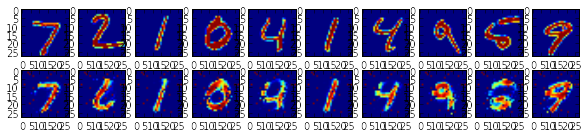

In [2]:
# from: http://blog.csdn.net/marsjhao/article/details/68950697
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt

# 导入MNIST数据
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

learning_rate = 0.01
training_epochs = 10
batch_size = 256
display_step = 1
examples_to_show = 10
n_input = 784

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

# 用字典的方式存储各隐藏层的参数
n_hidden_1 = 256 # 第一编码层神经元个数
n_hidden_2 = 128 # 第二编码层神经元个数
# 权重和偏置的变化在编码层和解码层顺序是相逆的
# 权重参数矩阵维度是每层的 输入*输出，偏置参数维度取决于输出层的单元数
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}

# 每一层结构都是 xW + b
# 构建编码器
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# 构建解码器
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# 构建模型
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# 预测
y_pred = decoder_op
y_true = X

# 定义代价函数和优化器
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2)) #最小二乘法
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

with tf.Session() as sess:
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)
    # 首先计算总批数，保证每次循环训练集中的每个样本都参与训练，不同于批量训练
    total_batch = int(mnist.train.num_examples/batch_size) #总批数
    for epoch in range(training_epochs):
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)  # max(x) = 1, min(x) = 0
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
    print("Optimization Finished!")

    encode_decode = sess.run(
        y_pred, feed_dict={X: mnist.test.images[:examples_to_show]})
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    plt.show()